<a href="https://colab.research.google.com/github/aparnapandey08/Sign_Predictor/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-j5nqi1_p
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-j5nqi1_p
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content'


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


EPOCHS=25
LR=0.003
IMG_SIZE=320
BATCH_SIZE=16

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[3]

image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

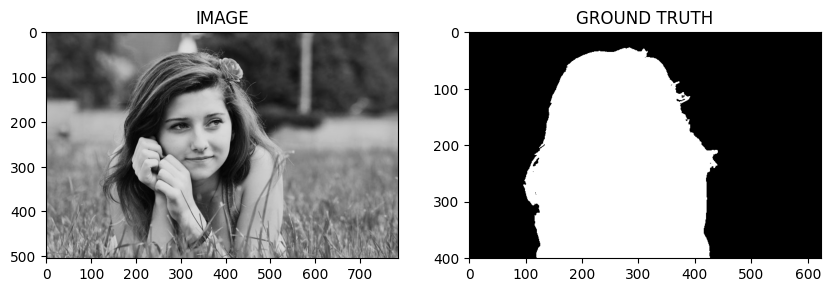

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE,always_apply=True),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes=0)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE,always_apply=True)
  ],is_check_shapes=0)

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
   self.df=df
   self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)#(h,w,c)
    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image) / 255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [ ]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


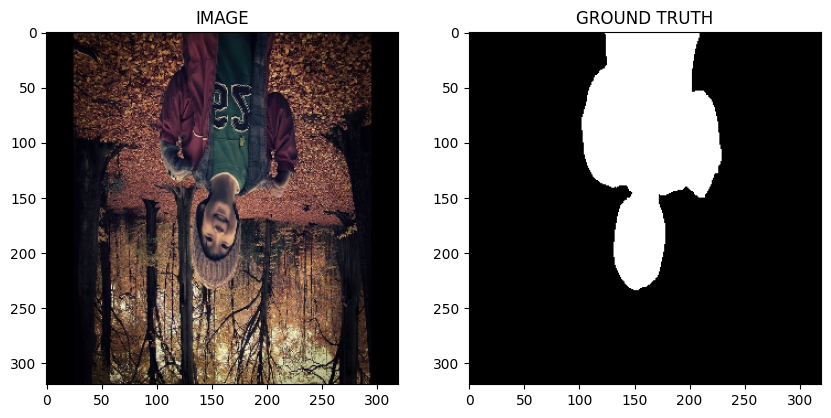

In [ ]:
idx=21
image,mask = trainset[idx]
helper.show_image(image,mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"total number of batches in trainloader : {len(trainloader)}")
print(f"total number of batches in validloader: {len(validloader)}")

total number of batches in trainloader : 15
total number of batches in validloader: 4


In [ ]:
for image, mask in trainloader :
 break

print(f"one batch image shape:{image.shape}")
print(f"one batch mask shape:{mask.shape}")

one batch image shape:torch.Size([16, 3, 320, 320])
one batch mask shape:torch.Size([16, 1, 320, 320])


In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks != None:
     loss1=DiceLoss(mode='binary')(logits,masks)
     loss2=nn.BCEWithLogitsLoss()(logits,masks)
     return logits,loss1+loss2
    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [ ]:

def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)


In [ ]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss =train_fn(trainloader,model,optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch:{i+1} Train_Loss:{train_loss} Valid_Loss:{valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
Epoch:1 Train_Loss:0.8561480561892192 Valid_Loss:1.8040691316127777


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


SAVED MODEL
Epoch:2 Train_Loss:0.4561177670955658 Valid_Loss:0.4941876605153084


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


SAVED MODEL
Epoch:3 Train_Loss:0.3147232989470164 Valid_Loss:0.3921263962984085


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


SAVED MODEL
Epoch:4 Train_Loss:0.23763770759105682 Valid_Loss:0.2791842930018902


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch:5 Train_Loss:0.261444957057635 Valid_Loss:0.30646533891558647


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


SAVED MODEL
Epoch:6 Train_Loss:0.25415381987889607 Valid_Loss:0.25329064577817917


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Epoch:7 Train_Loss:0.2503521571556727 Valid_Loss:0.30972935259342194


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


SAVED MODEL
Epoch:8 Train_Loss:0.19671897143125533 Valid_Loss:0.24136583879590034


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch:9 Train_Loss:0.1752186506986618 Valid_Loss:0.2768893986940384


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Epoch:10 Train_Loss:0.1941414435704549 Valid_Loss:0.26721328124403954


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


SAVED MODEL
Epoch:11 Train_Loss:0.15470847288767497 Valid_Loss:0.22345202043652534


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch:12 Train_Loss:0.13942365447680155 Valid_Loss:0.3030499517917633


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch:13 Train_Loss:0.15015952438116073 Valid_Loss:0.29551980271935463


100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


SAVED MODEL
Epoch:14 Train_Loss:0.1370951533317566 Valid_Loss:0.18836955353617668


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Epoch:15 Train_Loss:0.11875959237416585 Valid_Loss:0.20664310827851295


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch:16 Train_Loss:0.146685828268528 Valid_Loss:0.21615438163280487


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch:17 Train_Loss:0.13140063136816024 Valid_Loss:0.32579590752720833


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch:18 Train_Loss:0.13648687799771628 Valid_Loss:0.19221845641732216


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Epoch:19 Train_Loss:0.14063821285963057 Valid_Loss:0.22535329312086105


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch:20 Train_Loss:0.1333555484811465 Valid_Loss:0.2001524120569229


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


SAVED MODEL
Epoch:21 Train_Loss:0.12753554433584213 Valid_Loss:0.1847817748785019


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch:22 Train_Loss:0.11239766130844751 Valid_Loss:0.23625962436199188


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


SAVED MODEL
Epoch:23 Train_Loss:0.10792550345261892 Valid_Loss:0.1748213842511177


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Epoch:24 Train_Loss:0.10210265318552653 Valid_Loss:0.2011174000799656


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

Epoch:25 Train_Loss:0.11511921286582946 Valid_Loss:0.20822414010763168


In [ ]:
idx=20

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask =model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

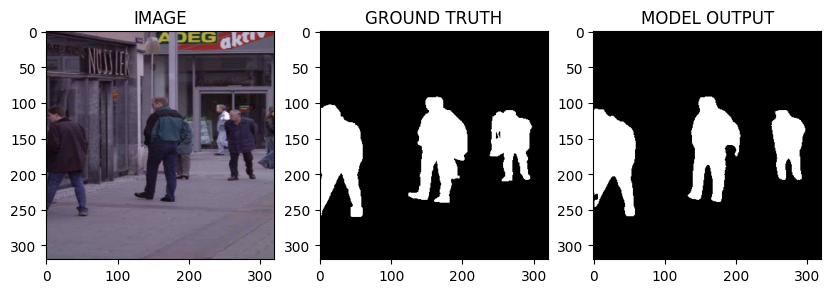

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze())